In [1]:
import collections
import numpy as np
import graphviz
from IPython.display import display


In [2]:
class Node:
    """Represents a node in the decision tree."""
    def __init__(self, is_leaf=False, label=None, test_cond=None, children=None, info_gain=None):
        self.is_leaf = is_leaf
        self.label = label
        self.test_cond = test_cond
        self.children = children if children is not None else {}
        self.info_gain = info_gain


class TestCondition:
    """Represents the test condition at an internal node."""
    def __init__(self, feature_index, split_val):
        self.feature_index = feature_index
        self.split_val = split_val


    def __call__(self, row):
        """Applies the test condition to a single data record."""
        return row[self.feature_index] == self.split_val


# -----------------------------------------------------------
# Helper Functions for Information Gain
# -----------------------------------------------------------


def calculate_entropy(E):
    """
    Calculates the entropy for a given set of data records.
    """
    if not E:
        return 0.0
    
    labels = [e[-1] for e in E]
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    probabilities = counts / len(E)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy


def calculate_information_gain(parent_E, child_Ev_list):
    """
    Calculates the information gain for a split.
    """
    N_parent = len(parent_E)
    I_parent = calculate_entropy(parent_E)
    
    I_children = 0.0
    for Ev in child_Ev_list:
        N_child = len(Ev)
        if N_child > 0:
            I_children += (N_child / N_parent) * calculate_entropy(Ev)
            
    gain = I_parent - I_children
    return gain

In [3]:
def find_best_split(E, F):
    """
    Finds the best split based on Information Gain.
    """
    best_gain = -1
    best_condition = None
    
    parent_E = E
    
    for feature_index in F:
        feature_values = {e[feature_index] for e in E}
        
        # We only consider features with more than one unique value to split on
        if len(feature_values) <= 1:
            continue
            
        for split_val in feature_values:
            # Create a test condition for this split
            test_cond = TestCondition(feature_index, split_val)
            
            # Partition the data
            Ev_true = [e for e in E if test_cond(e)]
            Ev_false = [e for e in E if not test_cond(e)]
            
            # Calculate gain for this split
            current_gain = calculate_information_gain(parent_E, [Ev_true, Ev_false])
            
            if current_gain > best_gain:
                best_gain = current_gain
                best_condition = test_cond
                
    return best_condition, best_gain


# -----------------------------------------------------------
# The main TreeGrowth Algorithm (with IG)
# -----------------------------------------------------------


def TreeGrowth(E, F):
    """
    Recursive function to grow a decision tree using Information Gain.
    """
    if stopping_cond(E):
        leaf = Node(is_leaf=True)
        leaf.label = Classify(E)
        return leaf
    else:
        best_condition, info_gain = find_best_split(E, F)
        
        if info_gain <= 0: # No good split found
            leaf = Node(is_leaf=True)
            leaf.label = Classify(E)
            return leaf


        root = Node(test_cond=best_condition, info_gain=info_gain)
        
        F_new = F[:]
        if best_condition.feature_index in F_new:
            F_new.remove(best_condition.feature_index)
            
        for outcome in [True, False]:
            if outcome:
                Ev = [e for e in E if best_condition(e)]
            else:
                Ev = [e for e in E if not best_condition(e)]
            
            child = TreeGrowth(Ev, F_new)
            root.children[outcome] = child
            
        return root

In [4]:
def stopping_cond(E):
    if not E:
        return True
    labels = [e[-1] for e in E]
    return len(set(labels)) <= 1


def Classify(E):
    if not E:
        return None
    labels = [e[-1] for e in E]
    return max(set(labels), key=labels.count)


# -----------------------------------------------------------
# Visualization Functions (updated for Info Gain)
# -----------------------------------------------------------


def visualize_tree(root, feature_names):
    dot = graphviz.Digraph(comment='Decision Tree', format='svg')
    
    def add_nodes_edges(graph, node, parent_name=None, edge_label=""):
        node_id = str(id(node))
        
        if node.is_leaf:
            label = f"Leaf\nClass: {node.label}"
            graph.node(node_id, label=label, shape="box", style="filled", color="lightblue")
        else:
            feature_name = feature_names[node.test_cond.feature_index]
            split_val = node.test_cond.split_val
            info_gain_label = f"Gain={node.info_gain:.4f}"
            label = f"Split on '{feature_name}'\nValue: '{split_val}'\n{info_gain_label}"
            graph.node(node_id, label=label, shape="oval", style="filled", color="lightgreen")
            
            for outcome, child in node.children.items():
                if child:
                    edge_label_text = f"== '{split_val}'" if outcome else f"!= '{split_val}'"
                    add_nodes_edges(graph, child, parent_name=node_id, edge_label=edge_label_text)
        
        if parent_name:
            graph.edge(parent_name, node_id, label=edge_label)


    add_nodes_edges(dot, root)
    return dot


--- Demonstration of Information Gain Calculation ---
Parent Node Entropy: 1.5305
Split on 'color' (== 'green'): Information Gain = 0.9911
Split on 'size' (== 'small'): Information Gain = 0.6305

--- Building and Visualizing the Decision Tree ---


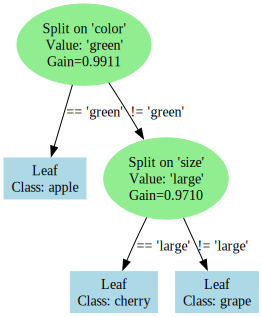

In [5]:
# -----------------------------------------------------------
# Example Usage and Demonstration
# -----------------------------------------------------------

if __name__ == "__main__":
    E = [
        ('green', 'small', 'apple'),
        ('green', 'large', 'apple'),
        ('red', 'small', 'grape'),
        ('red', 'large', 'cherry'),
        ('red', 'large', 'cherry'),
        ('red', 'small', 'grape'),
        ('green', 'small', 'apple'),
        ('red', 'large', 'cherry'),
        ('green', 'small', 'apple'),
    ]
    
    feature_names = ["color", "size"]
    F = [0, 1]
    
    print("--- Demonstration of Information Gain Calculation ---")
    parent_entropy = calculate_entropy(E)
    print(f"Parent Node Entropy: {parent_entropy:.4f}")
    
    # Calculate gain for 'color'
    split_val_color = 'green'
    test_cond_color = TestCondition(feature_index=0, split_val=split_val_color)
    Ev_true_color = [e for e in E if test_cond_color(e)]
    Ev_false_color = [e for e in E if not test_cond_color(e)]
    gain_color = calculate_information_gain(E, [Ev_true_color, Ev_false_color])
    print(f"Split on 'color' (== '{split_val_color}'): Information Gain = {gain_color:.4f}")
    
    # Calculate gain for 'size'
    split_val_size = 'small'
    test_cond_size = TestCondition(feature_index=1, split_val=split_val_size)
    Ev_true_size = [e for e in E if test_cond_size(e)]
    Ev_false_size = [e for e in E if not test_cond_size(e)]
    gain_size = calculate_information_gain(E, [Ev_true_size, Ev_false_size])
    print(f"Split on 'size' (== '{split_val_size}'): Information Gain = {gain_size:.4f}")
    
    print("\n--- Building and Visualizing the Decision Tree ---")
    decision_tree_root = TreeGrowth(E, F)
    
    # ✅ Generate visualization as SVG and display inline
    tree_visualization = visualize_tree(decision_tree_root, feature_names)
    svg_code = tree_visualization.pipe(format="svg").decode("utf-8")
    from IPython.display import SVG
    display(SVG(svg_code))
